openslideのPythonバインディングのインストール

In [0]:
%pip install openslide-python

Python interpreter will be restarted.
Collecting openslide-python
 Downloading openslide-python-1.1.2.tar.gz (316 kB)
Requirement already satisfied: Pillow in /local_disk0/.ephemeral_nfs/envs/pythonEnv-4a6fcb54-19c5-4296-98dc-b315ef8a1660/lib/python3.8/site-packages (from openslide-python) (8.0.1)
Building wheels for collected packages: openslide-python
 Building wheel for openslide-python (setup.py): started
 Building wheel for openslide-python (setup.py): finished with status 'done'
 Created wheel for openslide-python: filename=openslide_python-1.1.2-cp38-cp38-linux_x86_64.whl size=26958 sha256=acc161dbb8cece97c2bb4e62aafcedcb8cbd275633c6690a7cfd5e00d798097c
 Stored in directory: /root/.cache/pip/wheels/54/f7/99/15df0aea11eefca84d990052a0133ead40443e8abe22d18a11
Successfully built openslide-python
Installing collected packages: openslide-python
Successfully installed openslide-python-1.1.2
Python interpreter will be restarted.

In [0]:
dbutils.widgets.removeAll()

# 機械学習による病理画像分析の自動化

### Whole Slide Image Segmentation

こちらは以下の記事で引用されているサンプルノートブックとなります。

> [Databricksにおける機械学習による病理画像分析の自動化 \- Qiita](https://qiita.com/taka_yayoi/items/3929677d4e0c9dffaef4)

このノートブックでは、癌細胞の転移の確率をWhole Slide Image(WSI)上にマッピングするモデルをトレーニングするワークフローにおいて、ステップバイステップでSparkのディープラーニングの機能を説明します。

ここでは、[Camelyon16 Grand Challenge](http://gigadb.org/dataset/100439)から得られるWSI、転移している領域を手書きした注釈を使用します。

まず初めに、注釈データに基づいて腫瘍・正常パッチ(画像の断片)を生成するためにApache Sparkの並列分散処理機能を活用します。

**参考論文**
- [病理診断におけるデジタル化と AI の現状(PDF)](https://www.jstage.jst.go.jp/article/haigan/60/2/60_81/_pdf/-char/ja)

> ただし WSI による病理画像は極めてサイズが大きく， そのまま CNN で解析することはできない. 任意の大きさ(128×128px 程度)の切り取り画像(パッチ)に切り分け， パッチごとに解析を行うことが一般的である

後段のモデルでは生成したパッチの特徴量を使用します。この特徴量を計算するために事前学習済みディープラーニングモデルを使います。このような考え方は、事前学習モデルから新しいモデルに知識(特徴量のエンコーディングなど)を移し替えることから、*転移学習*と呼ばれます。

このノートブックでは、以下を実施します：
* OpenSlideを用いた注釈に基づく腫瘍・正常パッチの生成
* 推論のためのデータ準備
* 分散処理による特徴量エンジニアリング
  * Apache Sparkのバイナリーファイルデータソースによるデータロード
  * 特徴量抽出のためのモデルのロードおよび準備
  * 事前学習済みモデルによる特徴量の計算
* スライドのセグメントに対して腫瘍・正常の予測を行う二値分類器のトレーニング
* (MLflowでロギングされた)トレーニング済みモデルを用いて新規スライドにおける腫瘍の確率に基づくヒートマップの投影

要件：
* Databricksランタイム5.5ML以上
* 2〜8台のワーカーから構成されるr4シリーズ(AWS)、Dシリーズ(Azure)のインスタンス
* クラスターへのopenslide-pythonのインストール(cmd1、cmd7を参照)

<table>
  <tr><th>作者</th><th>Databricks Japan</th></tr>
  <tr><td>日付</td><td>2021/05/18</td></tr>
  <tr><td>バージョン</td><td>1.3</td></tr>
  <tr><td>クラスター</td><td>DBR8.2ML</td></tr>
</table>

<img src="https://databricks.com/wp-content/themes/databricks/assets/images/header_logo_2x.png" alt="logo" width="150"/>

## ステップ1: データ準備
_癌の転移箇所の輪郭から腫瘍・正常パッチを生成します。_

転移箇所の輪郭情報（領域を構成するポリゴン）は病理学者によって目視で作成されたものであり、XML形式で提供されています。ここでは、[Baidu Research NCRF project](https://github.com/baidu-research/NCRF)において作成された注釈情報の編集版のコピーを使用します。この注釈情報を用いて、腫瘍を含むパッチ(画像のサブセット)、正常な細胞を含むパッチを生成します。次に、これらラベル付けされたパッチを用いて、どの領域に主要の転移があるのかを識別する_画像セグメンテーションモデル_をトレーニングします。

これらの画像を操作する際、[OpenSlideライブラリ](https://openslide.org/)を使用します。ライブラリをインストールするためには、マシンが起動する際に実行される[init script](https://docs.databricks.com/user-guide/clusters/init-scripts.html)を使用します。

このワークフローを実行する際に、最初に`openslide-tools`をクラスターにインストールする`Init Script`を作成する必要があります。このスクリプトを[使用するクラスターにアタッチ](https://docs.databricks.com/user-guide/clusters/init-scripts.html#configure-a-cluster-scoped-init-script)する必要があります。initスクリプトを作成した後、あなたが使用するクラスターの`Init Script`設定ペインに`/openslide/openslide-tools.sh`のパスを追加してください。

![](https://sajpstorage.blob.core.windows.net/demo20210518-digital-pathology/init_script.png)

In [0]:
# openslide-toolsをインストールするinitスクリプトを /openslide/openslide-tools.sh として作成します。
# initスクリプト作成・設定後はこちらのセルの実行は不要です。
dbutils.fs.mkdirs('/openslide/')
dbutils.fs.rm('/openslide/openslide-tools.sh', True)
dbutils.fs.put('/openslide/openslide-tools.sh',
               """
               #!/bin/bash
               apt-get install -y openslide-tools
               """)

Wrote 93 bytes.
Out[2]: True

続ける前にクラスターを再起動しましょう。この作業はこのワークフローを**初めて**実行する際にのみ必要であることに注意してください。

In [0]:
import os
import subprocess
from pyspark.sql import functions as F
import re

# Username を取得
username_raw = dbutils.notebook.entry_point.getDbutils().notebook().getContext().tags().apply('user')
# Username の英数字以外を除去し、全て小文字に変換
username = re.sub('[^A-Za-z0-9]+', '', username_raw).lower()
# ファイル格納パス
work_path = f"/tmp/{username}/digital-pathology/"

# パラメーターを設定するウィジェットを追加します
dbutils.widgets.text('PATCH_SIZE',"299")
dbutils.widgets.text('MAX_N_PATCHES','100000')
#dbutils.widgets.text('MAX_N_PATCHES','10000')

PATCH_SIZE=int(dbutils.widgets.get('PATCH_SIZE'))
MAX_N_PATCHES=int(dbutils.widgets.get('MAX_N_PATCHES'))
BASE_PATH=work_path

print(f"MAX_N_PATCHES:{MAX_N_PATCHES} PATCH_SIZE:{PATCH_SIZE} BASE_PATH:{BASE_PATH}")

# クリーンアップ
dbutils.fs.rm(BASE_PATH, recurse=True)

# 注釈データのパス
WSI_TIF_PATH = "/databricks-datasets/med-images/camelyon16/"
LEVEL = 0

ANNOTATIONS_PATH = BASE_PATH+"/annotations/"
PATCH_PATH = BASE_PATH+"/patches/"
  
for path in [BASE_PATH, PATCH_PATH]:
  if not os.path.exists(('/dbfs/' + path)):
    print("path %s does not exist" % path)
    dbutils.fs.mkdirs(path)
    print("created path %s" % path)
  else:
    print("path %s exists"%path)

# 座標ファイルのダウンロード
dbutils.fs.rm(ANNOTATIONS_PATH, recurse=True)
dbutils.fs.mkdirs(ANNOTATIONS_PATH)

subprocess.call('wget https://raw.githubusercontent.com/baidu-research/NCRF/master/coords/tumor_train.txt',
                shell=True,
                cwd='/dbfs'+ANNOTATIONS_PATH)
subprocess.call('wget https://raw.githubusercontent.com/baidu-research/NCRF/master/coords/normal_train.txt',
                shell=True,
                cwd='/dbfs'+ANNOTATIONS_PATH)

print(dbutils.fs.head(ANNOTATIONS_PATH+'normal_train.txt', 111))

MAX_N_PATCHES:100000 PATCH_SIZE:299 BASE_PATH:/tmp/takaakiyayoidatabrickscom/digital-pathology/
path /tmp/takaakiyayoidatabrickscom/digital-pathology/ does not exist
created path /tmp/takaakiyayoidatabrickscom/digital-pathology/
path /tmp/takaakiyayoidatabrickscom/digital-pathology//patches/ does not exist
created path /tmp/takaakiyayoidatabrickscom/digital-pathology//patches/
[Truncated to first 111 bytes]
Tumor_094,80227,34836
Normal_123,67340,12864
Tumor_080,91939,70256
Tumor_089,38080,51520
Normal_135,22335,62080

データセットにあるスライドを見てみましょう。

In [0]:
display(dbutils.fs.ls(WSI_TIF_PATH))

path,name,size
dbfs:/databricks-datasets/med-images/camelyon16/normal_034.tif,normal_034.tif,2619372270
dbfs:/databricks-datasets/med-images/camelyon16/normal_035.tif,normal_035.tif,1441492022
dbfs:/databricks-datasets/med-images/camelyon16/normal_036.tif,normal_036.tif,1640940244
dbfs:/databricks-datasets/med-images/camelyon16/normal_037.tif,normal_037.tif,2146402708
dbfs:/databricks-datasets/med-images/camelyon16/normal_038.tif,normal_038.tif,1235015924
dbfs:/databricks-datasets/med-images/camelyon16/normal_039.tif,normal_039.tif,1952556356
dbfs:/databricks-datasets/med-images/camelyon16/normal_040.tif,normal_040.tif,2650872068
dbfs:/databricks-datasets/med-images/camelyon16/normal_041.tif,normal_041.tif,1926545504
dbfs:/databricks-datasets/med-images/camelyon16/normal_042.tif,normal_042.tif,914485186
dbfs:/databricks-datasets/med-images/camelyon16/normal_043.tif,normal_043.tif,1401539166


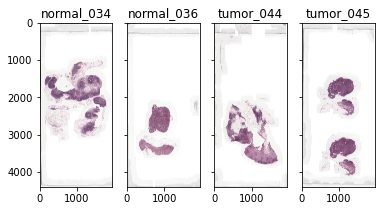

In [0]:
import numpy as np
import openslide
import matplotlib.pyplot as plt

f, axarr = plt.subplots(1,4,sharey=True)
i=0
for pid in ["normal_034","normal_036","tumor_044", "tumor_045"]:
  path = '/dbfs/%s/%s.tif' %(WSI_TIF_PATH,pid)
  slide = openslide.OpenSlide(path)
  axarr[i].imshow(slide.get_thumbnail(np.array(slide.dimensions)//50))
  axarr[i].set_title(pid)
  i+=1
  
display()

レベルを指定することでスライドの領域を抽出することも可能です。

[OpenSlide Python — OpenSlide Python 1\.1\.2 documentation](https://openslide.org/api/python/#openslide.OpenSlide.level_count)

> The number of levels in the slide. Levels are numbered from 0 (highest resolution) to level_count - 1 (lowest resolution).

0が最もズームインされた状態で、大きくなるほどズームアウトされます。

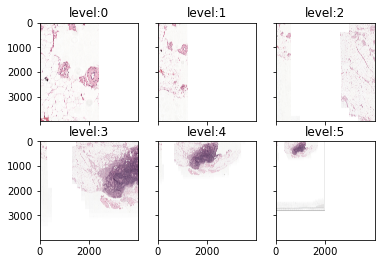

In [0]:
slide = openslide.OpenSlide('/dbfs/%s/normal_034.tif' %WSI_TIF_PATH)
image_datas=[]
region=[35034,131012] # 対象座標
size=[4000,4000] # 表示領域のサイズ
f, axarr = plt.subplots(2,3,sharex=True,sharey=True)

for level,ind in zip([0,1,2,3,4,5,6],[(0,0),(0,1),(0,2),(1,0),(1,1),(1,2)]):
  img = slide.read_region(region,level,size)
  axarr[ind].imshow(img)
  axarr[ind].set_title("level:%d"%level)

display()

ここでは、パッチ抽出関数をpythonの関数としてラップします。この関数は、スライドの名称、抽出すべきパッチの中心xy座標、パッチに対応するラベル(0が正常、1が腫瘍)を引数とします。そして、抽出した領域を`path/<name>_<x coord>_<y coord>_LABEL<label 0/1>.jpg`の形式で保存します。このpython関数をSparkのUDF(ユーザー定義関数)として登録し、並列実行することでパッチを生成します。

In [0]:
from pyspark.sql import functions as F
from pyspark.sql.types import StringType

def process_patch(name, x_center, y_center, label, patch_base_path=None, drop_coords=False):
  """
  Generate a patch given coordinate centers and return patch information.
  name: name of the wsi file 
  x_center: x coordinate of the center of the patch
  y_center: y coordinate of the center of the patch
  label: label of the patch based on annotation data
  patch_base_path: specify if different than where the default working directory is (used for scoring)
  drop_coords: boolean, if True then the coordinates will not be included in the image file name (will be used in scoring)
  """

  if not patch_base_path:
    patch_base_path = '/dbfs/' + PATCH_PATH
    
  wsi_path = '/dbfs' + WSI_TIF_PATH + name + '.tif'
  _x = int(x_center)
  _y = int(y_center)

  x = _x - PATCH_SIZE // 2
  y = _y - PATCH_SIZE // 2
  
  if drop_coords:
    patch_path = "/%s/%s_LABEL%s.jpg" % (patch_base_path, name, str(label))
  else:
    patch_path = "/%s/%s_%s_%s_LABEL%s.jpg" % (patch_base_path, name, str(x_center), str(y_center), str(label))

  slide = openslide.OpenSlide(wsi_path)
  img = slide.read_region((x, y), LEVEL, (PATCH_SIZE, PATCH_SIZE)).convert('RGB')
  img.save(patch_path)
  
  return(patch_path)

# SparkのUDFとして関数を登録します
process_patch_udf = F.udf(process_patch, StringType())

これで、注釈データに基づいて腫瘍・正常パッチの座標を含むデータフレームを作成できます。

In [0]:
# 正常パッチ座標をロードして label = 0 を割り当てます
df_coords_normal = (
  spark.read.csv(ANNOTATIONS_PATH+'/normal_train.txt').withColumn('label', F.lit(0))
)

# 腫瘍パッチ座標をロードして label = 1 を割り当てます
df_coords_tumor = (
  spark.read.csv(ANNOTATIONS_PATH+'/tumor_train.txt').withColumn('label', F.lit(1))
)

# 上記のパッチをUNIONで結合します
df_coords = df_coords_normal.union(df_coords_tumor).selectExpr('lower(_c0) as pid','_c1 as x_center', '_c2 as y_center', 'label')

display(df_coords)

pid,x_center,y_center,label
tumor_094,80227,34836,0
normal_123,67340,12864,0
tumor_080,91939,70256,0
tumor_089,38080,51520,0
normal_135,22335,62080,0
tumor_012,61280,57712,0
tumor_063,26560,184000,0
tumor_011,69010,110095,0
normal_027,30126,159761,0
tumor_016,38134,154000,0


確実に既存のWSIファイルの座標のみをパッチ生成関数に渡すように、既存のWSIファイルの一覧と座標のデータフレームをJOINします。

In [0]:
# WSI画像のパスを含むデータフレームを作成
df_wsi_path = (
  spark.createDataFrame(dbutils.fs.ls(WSI_TIF_PATH))
  .withColumn('name',F.regexp_replace('name', '.tif', ''))
  .withColumn('pid',F.lower(F.col('name')))
)

# 腫瘍・正常パッチの座標、ラベルのテーブルとJOIN
df_patch_info = (
  df_coords
  .join(df_wsi_path, on='pid')
  .selectExpr('pid','name','x_center','y_center','label')
)

display(df_patch_info)

pid,name,x_center,y_center,label
normal_034,normal_034,75034,101012,0
normal_034,normal_034,52347,93465,0
normal_034,normal_034,43275,96983,0
normal_034,normal_034,71411,89296,0
normal_034,normal_034,62898,107331,0
normal_034,normal_034,54143,89937,0
normal_034,normal_034,59035,78463,0
normal_034,normal_034,46218,98686,0
normal_034,normal_034,72251,118759,0
normal_034,normal_034,55273,80237,0


座標情報、ラベルに対応する`jpg`ファイルを生成するためにパッチ生成関数を実行します。後段の分析を高速に行うために、生成されたパッチのパスを`csv`ファイルに出力します。

**注意**
- `MAX_N_PATCHES`の数のパッチを生成するため、並列処理の場合でも処理に若干の時間を要することにあらかじめご注意ください。
- 参考値： `MAX_N_PATCHES`が100,000の場合、r4.2xlargeの8台構成で約10分

In [0]:
patch_path_df = df_patch_info.sample(1.0,False).limit(MAX_N_PATCHES).\
                repartition(1024).select(process_patch_udf('name','x_center','y_center','label').alias('path'))

# パス一覧を格納したファイルを保存
patch_path_df.write.csv(BASE_PATH+'/patch_path.csv', header = True)

In [0]:
patch_path_df.count()

Out[11]: 100000

## ステップ2: データのQC(品質管理)

パッチを作成後、データQCのために全ての画像をSparkデータフレームにロードします。

In [0]:
image_df = (
  spark.read.csv(BASE_PATH+'/patch_path.csv',header=True)
  .select('path', F.regexp_extract("path",r"LABEL(\d)",1).cast('int').alias('label'))
  .limit(MAX_N_PATCHES)
)

In [0]:
display(image_df)

path,label
//dbfs//tmp/takaakiyayoidatabrickscom/digital-pathology//patches//tumor_061_63552_152640_LABEL0.jpg,0
//dbfs//tmp/takaakiyayoidatabrickscom/digital-pathology//patches//tumor_064_71872_135488_LABEL0.jpg,0
//dbfs//tmp/takaakiyayoidatabrickscom/digital-pathology//patches//normal_062_22356_143715_LABEL0.jpg,0
//dbfs//tmp/takaakiyayoidatabrickscom/digital-pathology//patches//tumor_045_56783_98300_LABEL1.jpg,1
//dbfs//tmp/takaakiyayoidatabrickscom/digital-pathology//patches//tumor_049_60198_97704_LABEL0.jpg,0
//dbfs//tmp/takaakiyayoidatabrickscom/digital-pathology//patches//tumor_049_15269_127542_LABEL1.jpg,1
//dbfs//tmp/takaakiyayoidatabrickscom/digital-pathology//patches//tumor_044_83617_184474_LABEL1.jpg,1
//dbfs//tmp/takaakiyayoidatabrickscom/digital-pathology//patches//normal_057_29051_120527_LABEL0.jpg,0
//dbfs//tmp/takaakiyayoidatabrickscom/digital-pathology//patches//normal_043_51066_182875_LABEL0.jpg,0
//dbfs//tmp/takaakiyayoidatabrickscom/digital-pathology//patches//tumor_053_65245_149563_LABEL1.jpg,1


データセットにおける腫瘍・正常の分布を確認してみましょう。

In [0]:
display(image_df.select('label').groupBy('label').count())

label,count
0,44000
1,56000


## ステップ3: トレーニング

データの前処理が終わったので、二値分類器のトレーニングの準備が整ったことになります。このタスクでは、転移学習アプローチをとります。ここでは、大量の腫瘍・正常パッチから特徴量を並列処理で抽出する際に、`pandas udf`を活用します。特徴量抽出には`InceptionV3`のアーキテクチャーと重み情報を使用し、以降ではデモンストレーションとして、分類を行うためにsparkmlのロジスティック回帰を使用します。

**参考情報**
- [転移学習とは \| メリット・デメリット・ファインチューニングの意味 \| Ledge\.ai](https://ledge.ai/transfer-learning/)
- [転移学習とは？ディープラーニングで期待の「転移学…｜Udemy メディア](https://udemy.benesse.co.jp/data-science/deep-learning/transfer-learning.html)
- [InceptionV3](https://keras.io/api/applications/inceptionv3/)
- [第10回　学習済みInception\-v3モデルを使った画像認識アプリケーションを作ろう｜Tech Book Zone Manatee](https://book.mynavi.jp/manatee/detail/id=77514)

> Googleによって開発されたInception-v3は、ILSVRCという大規模画像データセットを使った画像識別タスク用に1,000クラスの画像分類を行うよう学習されたモデルで、非常に高い精度の画像識別を達成しています。

In [0]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input 
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np
from pyspark.sql.functions import col, pandas_udf, PandasUDFType

In [0]:
# インセプションモデルのロード
model = InceptionV3(include_top=False)
model.summary() 

Downloading data from https://storage.googleapis.com/tensorflow/keras-applications/inception_v3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
 8192/87910968 [..............................] - ETA: 1s 245760/87910968 [..............................] - ETA: 17s 3735552/87910968 [>.............................] - ETA: 2s  8396800/87910968 [=>............................] - ETA: 2s14417920/87910968 [===>..........................] - ETA: 1s20234240/87910968 [=====>........................] - ETA: 1s25174016/87910968 [=======>......................] - ETA: 1s32382976/87910968 [==========>...................] - ETA: 0s39673856/87910968 [============>.................] - ETA: 0s46931968/87910968 [===============>..............] - ETA: 0s50339840/87910968 [================>.............] - ETA: 0s57450496/87910968 [==================>...........] - ETA: 0s64528384/87910968 [=====================>........] - ETA: 0s71901184/87910968 [=======================>......] - ETA: 0s75505664/87910968 [========================>.....] - ETA: 0s82747392/87910968 [===========================>..] - ETA: 0s87916544/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type) Output Shape Param # Connected to 
==================================================================================================
input_1 (InputLayer) [(None, None, None, 0 
__________________________________________________________________________________________________
conv2d (Conv2D) (None, None, None, 3 864 input_1[0][0] 
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96 conv2d[0][0] 
__________________________________________________________________________________________________
activation (Activation) (None, None, None, 3 0 batch_normalization[0][0] 
__________________________________________________________________________________________________
conv2d_1 (Conv2D) (None, None, None, 3 9216 activation[0][0] 
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96 conv2d_1[0][0] 
__________________________________________________________________________________________________
activation_1 (Activation) (None, None, None, 3 0 batch_normalization_1[0][0] 
__________________________________________________________________________________________________
conv2d_2 (Conv2D) (None, None, None, 6 18432 activation_1[0][0] 
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, None, None, 6 192 conv2d_2[0][0] 
__________________________________________________________________________________________________
activation_2 (Activation) (None, None, None, 6 0 batch_normalization_2[0][0] 
_______________

In [0]:
# 全てのワーカーノードで重み情報を利用できるように、重み情報をブロードキャストします
broadcaseted_model_weights = sc.broadcast(model.get_weights())
def model_fn():
  """
  Returns a InceptionV3 model with top layer removed and broadcasted pretrained weights.
  """
  model = InceptionV3(weights=None, include_top=False)
  model.set_weights(broadcaseted_model_weights.value)
  return model

In [0]:
from PIL import Image
import io
import numpy as np
import pandas as pd

def preprocess(content):
  """
  Preprocesses raw image bytes for prediction, making sure it works 
  """
  img = Image.open(content)
  arr = img_to_array(img)
  return preprocess_input(arr)

def featurize_series(model, content_series):
  """
  Featurize a pd.Series of raw images using the input model.
  :return: a pd.Series of image features
  """
  input = np.stack(content_series.map(preprocess))
  preds = model.predict(input)
  # いくかのレイヤーでは、アウトプットの特徴量は多次元のテンソルになります
  # Sparkデータフレームで格納しやすいように特徴量テンソルをベクトルに変換します
  output = [p.flatten() for p in preds]
  return pd.Series(output)

In [0]:
from pyspark.ml.linalg import VectorUDT, Vectors
from pyspark.sql import functions as F

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_pudf(content_series_iter):
  '''
  This method is a Scalar Iterator pandas UDF wrapping our featurization function.
  The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).
  
  :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
  '''
  # pandas UDFのスカラーイテレータで一度だけモデルを読み込んで以降のデータバッチでは再利用します
  # これによって大きなモデルのロードに要するオーバーヘッドを削減します
  model = model_fn()
  for content_series in content_series_iter:
    yield featurize_series(model, content_series)

to_vector_udf = F.udf(lambda x: Vectors.dense(x), VectorUDT())

/databricks/spark/python/pyspark/sql/pandas/functions.py:386: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
 warnings.warn(

In [0]:
# Arrowのバッチサイズを指定します
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

事前学習済みの[InceptionV3](https://arxiv.org/abs/1512.00567)モデルを用いて、画像データから特徴量を生成します。まず初めに、画像データセットを事前学習済みモデルによって新たな特徴量に変換し、特徴量を用いて二値分類器をトレーニングします。

In [0]:
# トレーニング用のデータセットとテスト用のデータセットを分割します
(train_img_df, test_img_df) = image_df.select('label',F.regexp_replace(F.col('path'),'dbfs:','/dbfs').alias('path')).randomSplit([0.7, 0.3], seed=42)

In [0]:
display(train_img_df)

label,path
0,//dbfs//tmp/takaakiyayoidatabrickscom/digital-pathology//patches//normal_034_10178_72884_LABEL0.jpg
0,//dbfs//tmp/takaakiyayoidatabrickscom/digital-pathology//patches//normal_034_10194_79153_LABEL0.jpg
0,//dbfs//tmp/takaakiyayoidatabrickscom/digital-pathology//patches//normal_034_10732_72798_LABEL0.jpg
0,//dbfs//tmp/takaakiyayoidatabrickscom/digital-pathology//patches//normal_034_10878_83729_LABEL0.jpg
0,//dbfs//tmp/takaakiyayoidatabrickscom/digital-pathology//patches//normal_034_11004_82658_LABEL0.jpg
0,//dbfs//tmp/takaakiyayoidatabrickscom/digital-pathology//patches//normal_034_11244_80817_LABEL0.jpg
0,//dbfs//tmp/takaakiyayoidatabrickscom/digital-pathology//patches//normal_034_12009_86770_LABEL0.jpg
0,//dbfs//tmp/takaakiyayoidatabrickscom/digital-pathology//patches//normal_034_12044_86964_LABEL0.jpg
0,//dbfs//tmp/takaakiyayoidatabrickscom/digital-pathology//patches//normal_034_12774_84292_LABEL0.jpg
0,//dbfs//tmp/takaakiyayoidatabrickscom/digital-pathology//patches//normal_034_13792_85582_LABEL0.jpg


In [0]:
train_df = train_img_df.repartition(128).select("label", featurize_pudf("path").alias("features")).select("label",to_vector_udf("features").alias('features_vec'))
test_df = test_img_df.repartition(128).select("label", featurize_pudf("path").alias("features")).select("label",to_vector_udf("features").alias('features_vec'))
print(train_df.count(),test_df.count())

69941 30059

以下の関数は、二値分類器をトレーニングし、MLflowを用いてモデルを保存します。加えて、各々のトレーニングの入力パラメーター、メトリクス(精度、トレーニング実行時刻)を記録します。

In [0]:
import mlflow
import mlflow.spark

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import pyspark.sql.functions as F
import time

def train(max_iter, reg_param, elastic_net_param):
  start_time = time.time()

  with mlflow.start_run(run_name="binary-classifier") as run:
    
    lr = LogisticRegression(featuresCol='features_vec',maxIter=max_iter, regParam=reg_param, elasticNetParam=elastic_net_param)
    model = lr.fit(train_df)
  
    _df = model.transform(test_df)
    _predictions = _df.select("prediction", "label")
  
    evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction")
    area_under_roc=evaluator.evaluate(_predictions)
    elapsed_time = time.time() - start_time
  
    # 全てのパラメーターとメトリクス、モデル自身をMLflowを用いで記録します
    mlflow.log_param("max_iter", max_iter)
    mlflow.log_param("reg_param", reg_param)
    mlflow.log_param("elastic_net_param", elastic_net_param)
  
    mlflow.log_metric("area_under_ROC", area_under_roc)
    mlflow.log_metric('elapsed_time', elapsed_time)
    mlflow.spark.log_model(model,'wsi-dt-model')
  
  return(area_under_roc)

以下の処理は生成した大量のパッチを用いてトレーニングを行いますので、推奨スペックのクラスターでない場合、処理に長い時間を要します。

In [0]:
# パラメーターを指定してトレーニングを実行します
max_iter, reg_param, elastic_net_param = 10, 0.1, 0.2
area_u_roc = train(max_iter, reg_param, elastic_net_param)
print('precision is %f'%area_u_roc)

precision is 0.842372

ノートブック上でMLflowのログを直接確認することができます。右上の`Experiment`ボタンを押してみてください。

## ステップ4: スコアリング

トレーニングしたモデルを用いて、癌が転移している可能性がある領域を識別します。

まず最初に、スライドと分析するセグメントの座標を受け取り、スコアリングに必要なパッチの生成に使用されるタイル(グリッド)の中心座標を格納したデータフレームを返却する関数を定義します。

In [0]:
from pyspark.sql.types import *

def generate_patch_grid_df(*args):
  x_min,x_max,y_min,y_max, slide_name = args
  
  x = np.array(range(x_min,x_max,PATCH_SIZE))
  y = np.array(range(y_min,y_max,PATCH_SIZE))
  xv, yv = np.meshgrid(x, y, indexing='ij')
  
  cSchema = StructType([
    StructField("x_center", IntegerType()),
    StructField("y_center", IntegerType()),
    StructField("i_j", StringType()),
  ])

  arr=[]
  for i in range(len(x)):
    for j in range(len(y)):
      x_center = int(xv[i,j].astype('int'))
      y_center = int(yv[i,j].astype('int'))
      arr+=[[x_center,y_center,"%d_%d"%(i,j)]]
  grid_size = xv.shape
  df = spark.createDataFrame(arr,schema=cSchema) 
  return(df,grid_size)

スライド上で事前に指定されたセグメント上のグリッドに基づいてパッチを生成します。

In [0]:
PATCH_SIZE = 299
x_min, x_max, y_min, y_max = (23437, 53337, 135815, 165715) # 予測対象領域
path = f"{BASE_PATH}ml/patches" # パッチの出力先
dbutils.fs.mkdirs(path)

patch_path = f"/dbfs{path}" # パッチの出力先(DBFSプレフィクスあり)

print(path, patch_path)

/tmp/takaakiyayoidatabrickscom/digital-pathology/ml/patches /dbfs/tmp/takaakiyayoidatabrickscom/digital-pathology/ml/patches
Out[60]: True

In [0]:
name = "tumor_058" # 予測対象スライド
df, grid_size = generate_patch_grid_df(x_min, x_max, y_min, y_max,name) # パッチグリッドの生成
df = df.selectExpr("'%s' as name"%name, "x_center", "y_center", "i_j as label", "'%s' as patch_base_path"%patch_path)
display(df)

name,x_center,y_center,label,patch_base_path
tumor_058,23437,135815,0_0,/dbfs/tmp/takaakiyayoidatabrickscom/digital-pathology/ml/patches
tumor_058,23437,136114,0_1,/dbfs/tmp/takaakiyayoidatabrickscom/digital-pathology/ml/patches
tumor_058,23437,136413,0_2,/dbfs/tmp/takaakiyayoidatabrickscom/digital-pathology/ml/patches
tumor_058,23437,136712,0_3,/dbfs/tmp/takaakiyayoidatabrickscom/digital-pathology/ml/patches
tumor_058,23437,137011,0_4,/dbfs/tmp/takaakiyayoidatabrickscom/digital-pathology/ml/patches
tumor_058,23437,137310,0_5,/dbfs/tmp/takaakiyayoidatabrickscom/digital-pathology/ml/patches
tumor_058,23437,137609,0_6,/dbfs/tmp/takaakiyayoidatabrickscom/digital-pathology/ml/patches
tumor_058,23437,137908,0_7,/dbfs/tmp/takaakiyayoidatabrickscom/digital-pathology/ml/patches
tumor_058,23437,138207,0_8,/dbfs/tmp/takaakiyayoidatabrickscom/digital-pathology/ml/patches
tumor_058,23437,138506,0_9,/dbfs/tmp/takaakiyayoidatabrickscom/digital-pathology/ml/patches


In [0]:
# パッチの作成
df.repartition(288).select(process_patch_udf('name', 'x_center', 'y_center', 'label', 'patch_base_path', F.lit("true"))).collect();

生成したタイルをデータフレームに再度読み込みます。このデータフレームのラベルはグリッド上のタイルの位置(例えば、ラベルが`i_j`の場合、i番目の行、j番目の列を意味します)を示していることに注意してください。このラベルは、あとのステップで腫瘍を含む確率に基づいてヒートマップを作成する際に使用します。

In [0]:
# 画像をデータフレームにロード
image_df = spark.read.format("image").load("file:" + patch_path)\
                                     .withColumn('label', F.regexp_extract("image.origin",r"LABEL(\d+_\d+)", 1))

image_df.repartition(100)

Out[75]: DataFrame[image: struct<origin:string,height:int,width:int,nChannels:int,mode:int,data:binary>, label: string]

In [0]:
display(image_df)

image label List(file:/dbfs/tmp/takaakiyayoidatabrickscom/digital-pathology/ml/patches/tumor_058_LABEL80_10.jpg, 299, 299, 3, 16, Binary image data placeholder. Access the image data field directly to view raw binary data., iVBORw0KGgoAAAANSUhEUgAAAGQAAABkCAIAAAD/gAIDAAByaklEQVR42hy79Vcj+bq3zb/wrPOcs0fakW68kQYad48Q94QkRHF3d3d3dwgWSEKIkAQIEtwdmm7au2emZ88+ez9vzbtWraz8kFRS37rv+3NdqYrWe4nsrUy9PamQ9YiGivqHy3nqEeXxhOSzdP3dwn4KJsX5SYDzM4SvEcnnOQ78HB/4mitvmH8n3r4Srso7Z9WDgi+as+8793N1k4eze8pemXpU8fXk/b8+//np/M3ns+sft2//vP18pTrYnlw65qvfqQ/+uninGZfMVQw2hZTGekf6PieDDCk+L7CeeggvPXgqOelEvAOzRPkbk32Msc5PwBjLCIQ5ozqi5Jq/stchHk/u6o6sXGqc47iH+BsHke0jWO4JTLe4PFL+wYBcUjZMfUWn24XR7EKTYcn8oqGZsqFsXFGoW0KUb3RbXLOkURQNiwO/JEItmf5GNIghPRoSfTypyMbmhbjn4OxZVr9ArH7xcdeDYl/TIAa4DFzKh6WL9rR2i//x0rrmr8mbBXQXDsKC6quLhprg0wlp+yOLlzOr8hahu46/6X+5mfyXm81DkO2v/m6PoEgT5HRR77el/c+qzT+2zz6tnuzwlsWNc2nETKZXSKh/RFdqx+qY4n7r9Fq99a+Lu4+bJx/WTi/nd2RNU8rmSc2ARDOs6E5tGc0ZbIlsodlyvJ4TnZ6gHB7B7B9BvPTRZWFld6rLWFQK3DzY6wXFT5+MMOW4Pw2Yrhx6v7A1k91RhM8eS+vY7VeBn0Ntf4b46OHRFkyyXUguIfuCp54vHaLbc5mucWS7cJoDN4+c3RBR0xHf3R7f3BpXPZQ5xHTmgAxR1j/7eLzAQ0wDCdbcZFTSWt9sYWA+xz0RYUG0/sXXXQ/pZ4hhesRgLdhRfuGn05qBnH7XJ2iti5nNwqBCiBGZaBtFsgkn2QTHQ1PaYhrWepUFQcWez+E2D31N/+Fm+au3za8+ns9gkX7RXUmtssaZtW7BycSivIWfgExAW5L89dFuOlDf58jkgIy5Wt6pZOlarn63uHUnO1zvlata5hfrZ1WN/M2ehb1hpahqfH1gSdoq4fiEWf7kbfsQavkP0OsHEE8DzEhJ3xvl/lBxH+oVHWXFwlozqQ7hLFfu+dzGejc/B5MEe46K9Q0TV0766fj5Pye4P0Z6aiPBBujGiOqDAZm0isd2i4SZBrk8waAtgkK9oiK8Y6L9IsYL2zYG5ivZ1X7PUFAjstNTpPWvIMfHIJZbZGNk7Wr/3NqgtC25PdQv3O0pCGKM99ZDgQ1JDJf4JHjCtWBnKKc3xCtJ63huKZ2SCregsjwTqPbBRGs20yWSZEOLhsRnkwtpTiFeL5CvfvG0/MndXTuA7hQa4p3o/hSBecXoTO5RtYiqgkv9nsPBRniQEcnxMcRdGxHkHNWV0/rt4Ozfl/fbI8oCWn6wZxjXPTwBltyX0Xs8uXIv1VzPr24Mz5+JNxbaZ1i+Ed4vMC5Pke46KJZP9MrA/Kf13Y9rh0v9ioqo6khYRGti23qf4qNib7l9lmxFgxkFpqLSx3L7cGaYWEgGzTES8yoIYoTkFfa/E25tdi0E2jLcHsNBBlTgm8SCEjMx+fGQhP7Mpj+27zKxGWgTKtQo0Fuf7KKDtv3VF2sRCNT40ezyX+dv36lPuzPak1BpdGcu2ZZNsuWwvWOyyOkfV05WBkS10Q1a1/Lt+oQGfxOKz3MS1oKOMKf6GGCJ9iyOZ0RLdEe0b0KgA8dTJ8D3BZLhHBrrnwQ1p9g8CvAwIEfAUmVNgixShr8B2s+Q4PwUZvE/Hq9+9sY6hQp65/66f//l+C6FkOamjXDXwXrrk0CmgQy/GF754PX8+hvp1saQ6Hh2+W7xYH1ouZRTHQPJSIBn1UU1iBtmZe3j8q6JjdEVUbNwsnroRLBxMbe21jXVndzs/RTn8BBFc+K0xzcyHelspzDy6xCWRzTQ/vURJfv9Cwf9crYzI9wnIcQzMdgtOs4vPhmWTjAPyiPl7I2pa0OrGI4hYAMi1IyJeh0OfUmn2QfXh1Sei9f/PDv5be9YM6RcqJsP9Ywg2dBpzszikOKZ+rHbla3PO4crYxKtH/vXx8LtzMBCol0Y2pzjZUiy+hXqoo0CXjqQ0RsPTaLYcUhWlDhQTGNUq78Bxv052P4pxO4p3M8Ez6+eKaDl+eoh3J6hrX4Cv37oB7OkRMDTTlR7//ny6Vq9z/DguDwjueoSPA0xzrowJ200zp6+zVv+qDpe7eXvTyr3Z9RLXcLxosGioILG2Ia5Gn4powpIlUxyai49LwGTGodJlLbPvVWelrHzUZZk219Bto8g/kaY5riOTEx2qGsEyzkSY0HHWNECHYJqg8uWmgVR3px8Ql4qIjkLlRbiFIaxCPJ6imE7x1SyaoopxSQbJs05GmMVCjfnwMzoFHtmLjF1e1D6cXn3UKCc75rZHFnRDKqH8/umK4dvFw+2JhVHCyt/nF58P7nUOl9Q/nX4Dsgykl0Q7CXN15jk8ATl+gQeB4veGVpujqwvCMxpj6rYH1TWR1Vb/MPR6bGf3UOw3SO4lz5K0iJpjmlEGBMhxjSQCT3IMzoZl9mb2Xu3cv7j4sMef7UhpsFXP9D+IQJkSnHXxXjoksEmOH7V2OXcxvHk4taIeH9GdafY+bh6fjCztjakkLYIWS5hYd6xmaS8itC6bGp5GDgxjZgymNfl9Qzkro20ewxy1kE4P4FyPCJbY9vD3UPS0NnATHB4AH79k3eAESY+IJFmxyK/4nBdwjJQWcHOcUCIBxjTovyycnFljcHNSagMkj2X8DoYa8WlOodzPaOKyHmS8gl1M/94dv10cU/Dkx0L125ke2/lh9sj8h2ecpMnfb+x92X/WGtzbOZOsXkws9wYV0d35Qa8xKOAE2VObomuuJrZWqwRyKonRSUDp7zVMk6hlwHUUxdr9T8gTz0s0zNsb1IjbRbFBCRQnENY3rGtKT0TJaMXgu39ye2x4skyTkVjRG04KNFbD+f+lOj3gu76BIV6iZfW8U8n1t5Kdj4vn3xZP327tPVp4/Cr5myHt6hsF8SCkriu0THgVLpTWBQkI9g7PpeW2xBV7acDc32EsPnFH5jNjg/BpNe0gfROQelwJbcS9pJs9Q9f+0cwiDEZa8MKMGW4PEATrRnRoHiiJcv/BQaIiGREYaR3ciI4tSe9uy25LciFgzIjwU1IUX4J/Qmde90KYVHX3cLmrWLnennjfFF9v7L/u+b2kLe2OaS6mt++X97/Y+9Ma3tEeCNRf1k/vleddaZ15AYWlrFqy5lli01T652Srui2TGQGzhiTCk+NBif66WPtHwTY/uSXhMoaLRw+m9/emVZ35LQ1ZbXMtMxJOue3xpZOZjYyCbkQfbL7A0iQXVAkOCYmIJViFwozJsFMsNn49LfzF9Mlo3m0zJqo0qXeBQ1Pfixa/rx+9HZx93xGk4PLZtgHx/ilMZ1jwn1SuR4xjbH1sxXjTCeOlzba/iHY+SnSQxtGtCbNlQ2fji8tNoq4nuH+xkSUNRf1igO3DIJa0iGmlFRCiqhuvC6sPNI/Lh6WGQfJ4rrFhXnG1EdUbgwoRLVTQ9l9k0VTc2X8harJoxHF6YT0jWj5cFL6dnX/7erex43T5b6FnvSuGEhsIjJurKDjhL+ipe6aO5yU/7Z59l1zWxtRlYrJSkZm14TWbI+q2uMbSK+YcFMaEKIQQ0KITyzemubyDBzoyJwu5ak6hZeSzY97V18u3v3r

In [0]:
#display(image_df.select("image.origin"))

分析対象のスライドからタイルを作成したので、モデルのURIを指定して学習済みモデルを読み込みます。特徴量を作成して、それぞれのタイルのスコアリングを行い、タイルに腫瘍が含まれる確率を記録していきます。

**注意**
- オリジナルのノートブックで使用されている`DeepImageFeaturizer`は、DBR 7.0以降では削除されているので、pandas UDFで特徴量抽出を行う必要があります。

[Deep Learning Pipelines \| Databricks on AWS](https://docs.databricks.com/applications/machine-learning/train-model/deep-learning-pipelines.html#transfer-learning)

In [0]:
# スコアリング対象の画像から特徴量を抽出してデータフレームを作成
image_df_with_path = image_df.select("image.origin", "label")
image_df_with_path = image_df_with_path.withColumn('dbfs_path', F.regexp_extract("origin", r"file\:(.*)", 1))

image_df_with_features = image_df_with_path.repartition(128).select("label", "dbfs_path", "origin", featurize_pudf("dbfs_path").alias("features")).select("label", "origin", to_vector_udf("features").alias('features_vec'))

In [0]:
#display(image_df_with_features.limit(1))

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import mlflow
import mlflow.spark
import mlflow.pyfunc

# MLflowのランを確認してトレーニング済みモデルのURIを指定します
model_uri="dbfs:/databricks/mlflow-tracking/3689871814054601/768352f2ec524d3897b5466888c21357/artifacts/wsi-dt-model"# 
model = mlflow.spark.load_model(model_uri=model_uri)

In [0]:
# 予測の実施
get_p_udf = udf(lambda v:float(v[1]), FloatType())
predictions_df = model.transform(image_df_with_features).\
                       withColumn('p', get_p_udf('probability')).drop('features', 'features_vec', 'probability', 'rawPrediction')

In [0]:
display(predictions_df.limit(10))

label,origin,prediction,p
73_99,file:/dbfs/tmp/takaakiyayoidatabrickscom/digital-pathology/ml/patches/tumor_058_LABEL73_99.jpg,0.0,0.14212655
99_3,file:/dbfs/tmp/takaakiyayoidatabrickscom/digital-pathology/ml/patches/tumor_058_LABEL99_3.jpg,0.0,0.2599266
79_96,file:/dbfs/tmp/takaakiyayoidatabrickscom/digital-pathology/ml/patches/tumor_058_LABEL79_96.jpg,0.0,0.23446216
22_73,file:/dbfs/tmp/takaakiyayoidatabrickscom/digital-pathology/ml/patches/tumor_058_LABEL22_73.jpg,0.0,0.103161246
6_46,file:/dbfs/tmp/takaakiyayoidatabrickscom/digital-pathology/ml/patches/tumor_058_LABEL6_46.jpg,0.0,0.31378064
6_58,file:/dbfs/tmp/takaakiyayoidatabrickscom/digital-pathology/ml/patches/tumor_058_LABEL6_58.jpg,0.0,0.31378064
7_61,file:/dbfs/tmp/takaakiyayoidatabrickscom/digital-pathology/ml/patches/tumor_058_LABEL7_61.jpg,0.0,0.31378064
9_13,file:/dbfs/tmp/takaakiyayoidatabrickscom/digital-pathology/ml/patches/tumor_058_LABEL9_13.jpg,0.0,0.31378064
21_81,file:/dbfs/tmp/takaakiyayoidatabrickscom/digital-pathology/ml/patches/tumor_058_LABEL21_81.jpg,0.0,0.24421753
38_92,file:/dbfs/tmp/takaakiyayoidatabrickscom/digital-pathology/ml/patches/tumor_058_LABEL38_92.jpg,0.0,0.21623091


## ステップ5: スライド上に予測結果を可視化する

PythonのPILライブラリを用いて、予測結果に基づくヒートマップを生成します。

In [0]:
pid = "tumor_058"
patch_path = f"/dbfs{BASE_PATH}ml/patches/"

In [0]:
inp_arr=predictions_df.select("origin", "label", "p").collect()
pred_arr = [(x.label,x.p) for x in inp_arr]
height=width=299

In [0]:
from pyspark.sql import functions as F
from PIL import Image
def stitch_images(*args):
  patch_path,pid,height,width,scale_f,pred_arr = args
  path = patch_path+"/"+pid
  n_x,n_y=grid_size
  img_size = int(scale_f*width),int(scale_f*height)
  
  total_width = img_size[0]*n_x
  total_height = img_size[1]*n_y
  
  new_im = Image.new('RGB', (total_width, total_height))
  x_offset = 0
  y_offset = 0
  
  for ij,p in pred_arr:
      i = int(ij.split('_')[0])
      j = int(ij.split('_')[1])
      
      x_offset = i*img_size[0]
      y_offset = j*img_size[1]
      
      temp_matrix = (p , 0.0, 0.0, 0.0,
                     0.0, 56/255, 0.0, 0.0,
                     0.0, 0.0, 0.0, 0.0 )
      
      pt = "{}_LABEL{}_{}.jpg".format(path,i,j)   
      img = Image.open(pt).resize(img_size).convert('RGB', temp_matrix)
      new_im.paste(img, (x_offset,y_offset))
      
      
  return(new_im)  

In [0]:
# 処理に10分程度時間を要します
patched_images = stitch_images(patch_path, pid, 299, 299, 0.2, pred_arr)

予測結果において赤色が密集している箇所は、癌細胞が転移している確率が高いことを示しています。

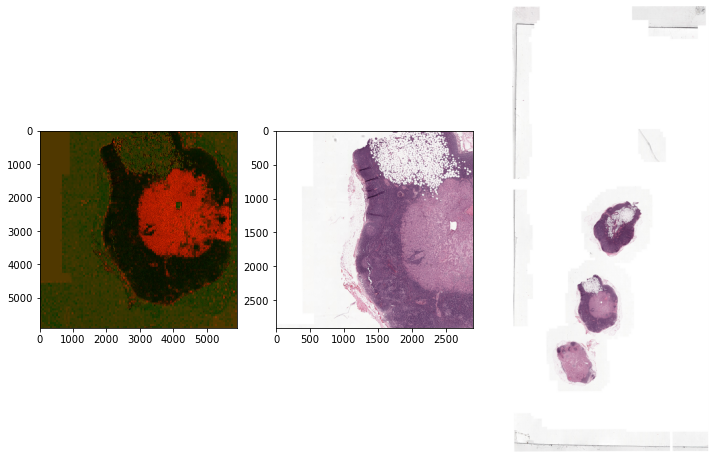

In [0]:
slide = openslide.OpenSlide('/dbfs/%s/%s.tif' %(WSI_TIF_PATH,pid))
region= [x_min,y_min]

size=[2900,2900]
slide_segment= slide.read_region(region,3,size)

f, axarr = plt.subplots(1,3)
axarr[0].imshow(patched_images) # 予測結果の表示
axarr[1].imshow(slide_segment) # 予測範囲の元画像
axarr[1].set_xlim=3000
axarr[1].set_ylim=3000
axarr[2].imshow(slide.get_thumbnail(np.array(slide.dimensions)//50)) # スライド全体
axarr[2].axis('off')
f.set_figheight(12)
f.set_figwidth(12)
display()

# END